In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
X, y = load_iris(return_X_y=True)

print(f'The shape of independent features: {X.shape}')
print(f'The shape of dependent features: {y.shape}')

The shape of independent features: (150, 4)
The shape of dependent features: (150,)


In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=142)

In [4]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [5]:
n_qubits = 4

dev = qml.device("default.qubit", wires=n_qubits)

# define the block
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)
    qml.RY(weights[2], wires=wires[0])
    qml.RY(weights[3], wires=wires[1])
    qml.CNOT(wires=wires)
    

@qml.qnode(dev)
def qnode(inputs, weights):
    # qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    # qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    qml.AngleEmbedding(inputs,wires=range(n_qubits))
    qml.MPS(
        wires=range(n_qubits),
        n_block_wires=2,
        block=block,
        n_params_block=4,
        template_weights=weights
    )
    # return [qml.expval(qml.PauliZ(wires=i)) for i in range(num_classes)]
    return qml.probs(wires=[n_qubits-1])


weight_shapes = {"weights": (3, 4)}
q_kernel = qml.qnn.TorchLayer(qnode, weight_shapes)

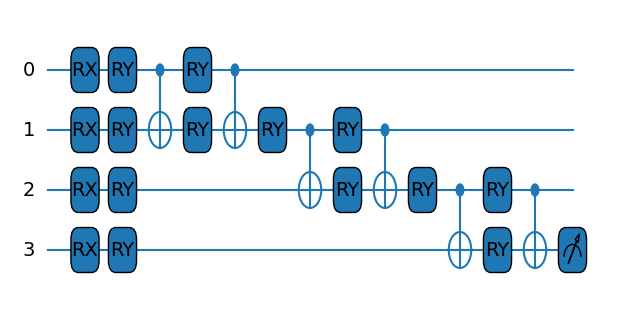

In [6]:
weights = np.random.random(size=[3, 4])
qml.drawer.use_style("default")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")(X[0].reshape(-1,),weights)
fig.set_size_inches((6, 3))

In [7]:
# Define a Hybrid-CNN model
class QuantumModel(nn.Module):
    def __init__(self):
        super(QuantumModel, self).__init__()
        self.fc1 = q_kernel
        self.fc2 = nn.Linear(2,3)
        self.fc3 = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [8]:
model = QuantumModel()
criterion = nn.CrossEntropyLoss()

In [9]:
optimizer = optim.Adamax(model.parameters(), lr=0.01)

q_loss_values = []
q_test_accs = []

# Training loop
num_epochs = 1500
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    # print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item()}')

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        # print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item()}', f'Test Accuracy: {100 * accuracy:.2f}%')
        q_loss_values.append(loss.item())
        q_test_accs.append(accuracy)

  0%|          | 0/1500 [00:00<?, ?it/s]d:\Tensor-Networks-quantum-circuits-for-supervised-learning\venv\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 1500/1500 [00:38<00:00, 38.61it/s]


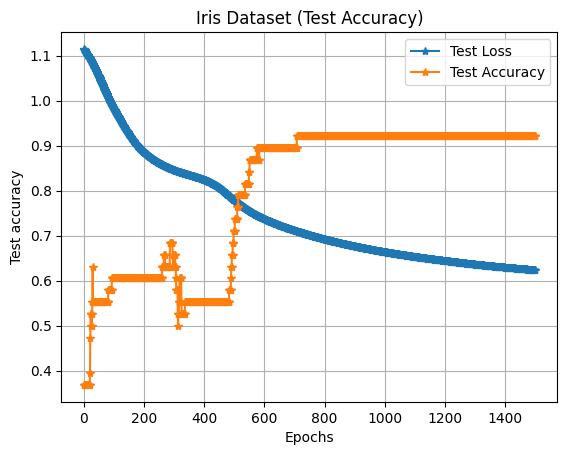

In [12]:
import matplotlib.pyplot as plt
plt.plot(q_loss_values, "-*")
plt.plot(q_test_accs, "-*")
plt.ylabel("Test accuracy")
plt.xlabel("Epochs")
plt.title('Iris Dataset (Test Accuracy)')
plt.legend(['Test Loss','Test Accuracy'])
plt.grid()

In [ ]:
print(f"The test accuracy: {q_test_accs[-1]}")

The test accuracy: 0.9210526315789473
